In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import math

### Setup

In [2]:
# Plot configuration
mpl.style.use("seaborn-colorblind")
mpl.rcParams.update(
    {
        "font.size": 12,
        "figure.facecolor": "w",
        "axes.facecolor": "w",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.top": False,
        "xtick.bottom": False,
        "ytick.right": False,
        "ytick.left": False,
    }
)

### Read in data

In [3]:
df_1a = pd.read_csv("files/aggregated_seq_sum.txt.xz", sep="\t")

#### Helper functions

In [4]:
scale_y = 1e6  # bp to Mbp
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))

In [5]:
# Get last two number of each barcode, fill unclassified with n
df_1a["barcode_number"] = df_1a["barcode_arrangement"].str.extract(r"(\d{2})$").fillna("Un")
barcode_order = sorted(df_1a["barcode_arrangement"].unique())
barcode_order_short = sorted(df_1a["barcode_number"].unique())

In [6]:
names = {
    'barcode08.sequenced.sorted.bam': 'barcode08_sequenced',
    'barcode08.unblocked.sorted.bam': 'barcode08_unblocked',
    'barcode09.sequenced.sorted.bam': 'barcode09_sequenced',
    'barcode09.unblocked.sorted.bam': 'barcode09_unblocked',
    'barcode10.sequenced.sorted.bam': 'barcode10_sequenced',
    'barcode10.unblocked.sorted.bam': 'barcode10_unblocked',
    'barcode11.sequenced.sorted.bam': 'barcode11_sequenced',
    'barcode11.unblocked.sorted.bam': 'barcode11_unblocked',
    'unclassified.sequenced.sorted.bam': 'unclassified_sequenced',
    'unclassified.unblocked.sorted.bam': 'unclassified_unblocked',
}
df_1b = pd.read_csv(
    "files/depth.tsv.xz", 
    sep="\t",
).drop("#CHROM", axis=1).set_index("POS").rename(columns=names)

In [7]:
# Regions being selected on each barcode
lookup = {
    "barcode08": (0, 1031096), 
    "barcode09": (1031096, 2062192), 
    "barcode10": (2062192, 3093288), 
    "barcode11": (3093288, 4124384),
    "unclassified": (0, 0),
}

In [12]:
res = [["Barcode", "Sequenced", "mean on", "mean off"]]
# loop each columns
for s in df_1b:
    if s.startswith("un") or not s.startswith("bar"): 
        continue
    # split barcode name and unblock state
    row, col = s.split("_")
    # get start stop of regons selected
    x0, x1 = lookup[row]
    # get the data for each base of this combination of barcode/unblock state
    data = df_1b[s]
    # off target data (outside selection region)
    off = data.iloc[:x0].to_list() + data.iloc[x1:].to_list()
    # on target data
    on = data.iloc[x0:x1]
    # add to results list
    res.append([row, col, on.mean(), np.array(off).mean()])

### Combine


In [11]:
# manually order labels for figure 1a
manual_order = [
    ('Sequenced', 'Control'), 
    ('Sequenced', 'Barcodes 08 & 11'), 
    ('Sequenced', 'Barcodes 09 & 10'), 
    ('Unblock sent', 'Control'), 
    ('Unblock sent', 'Barcodes 09 & 10'), 
    ('Unblock sent', 'Barcodes 08 & 11'),
]
# group by on data
gb = df_1a.groupby(["Sequenced", "Group"])

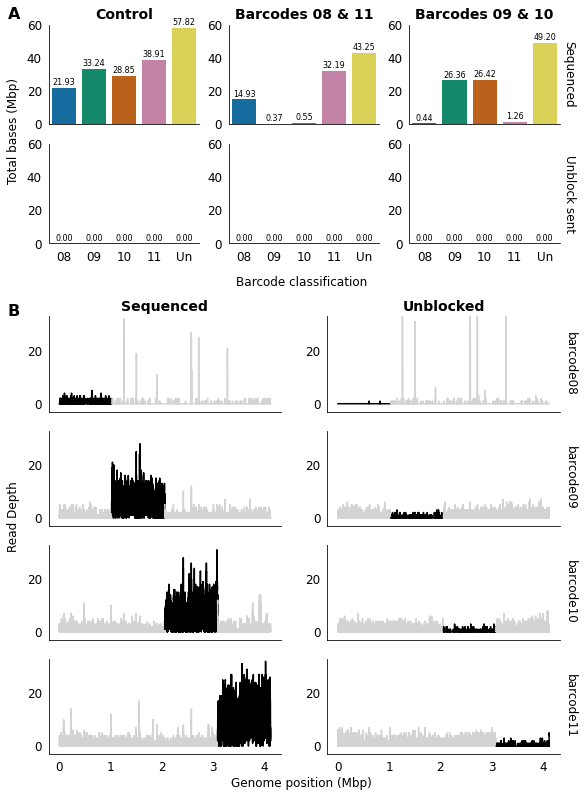

In [14]:
fig = plt.figure(figsize=(8, 11))
font_dict = {"fontsize": 14, "fontweight": "semibold"}
label_font_dict = {"fontsize": 16, "fontweight": "semibold"}

gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 2])
gsTop = gs[0].subgridspec(2, 3)
gsBot = gs[1].subgridspec(4, 2)
fig1a_facets = tuple(manual_order)
## Draw the figure 1a out manually using SNS barplot
for ind, (label, ax) in enumerate(zip(fig1a_facets, gsTop.subplots().flatten())):
    try:
        data = gb.get_group(label)
    except KeyError as e:
        data = pd.DataFrame(
            [
                {"barcode_number": x, "sequence_length_template": 0}
                for x in barcode_order_short
            ]
        )

    ax = sns.barplot(
        ax=ax,
        ci=None,
        data=data,
        order=barcode_order_short,
        x="barcode_number",
        y="sequence_length_template",
        estimator=np.sum,
    )
    ax.set(ylim=(0, 6 * 10 ** 7))
    if ax.get_subplotspec().is_first_row():
        ax.set_title(label[1], fontdict=font_dict)
    if ax.get_subplotspec().is_last_col():
        text = ax.annotate(
            label[0],
            xy=(1.02, 0.5),
            xycoords="axes fraction",
            rotation=270,
            ha="left",
            va="center",
        )
    if not ax.get_subplotspec().is_last_row():
        ax.xaxis.set_visible(False)
    else:
        ax.set_xlabel("")
    ax.set_ylabel("")
    ax.yaxis.set_major_formatter(ticks_y)
    for c in ax.containers:
        labels = ["{0:.2f}".format(x / scale_y) for x in c.datavalues]
        ax.bar_label(c, label_type="edge", labels=labels, fontsize=8, padding=1)
fig.text(0.5, 0.637, "Barcode classification", va="center", ha="center")
fig.text(0, 0.765, "Total bases (Mbp)", ha="center", rotation=90)

for ind, ax in enumerate(gsBot.subplots().flatten()):
    row, col = res[ind + 1][:2]
    x0, x1 = lookup[row]
    data = df_1b[f"{row}_{col.lower()}"]

    # subset data into
    a = data.iloc[:x0]  # before target
    b = data.iloc[x0:x1]  # target
    c = data.iloc[x1:]  # after target
    ax.plot(a.index, a, color="lightgrey")
    ax.plot(b.index, b, color="k")
    ax.plot(c.index, c, color="lightgrey")

    if not ax.get_subplotspec().is_last_row():
        ax.tick_params(labelbottom=False)
    if ax.get_subplotspec().is_first_row():
        ax.set_title(col[0].upper() + col[1:], fontdict=font_dict)
    if ax.get_subplotspec().is_last_col():
        text = ax.annotate(
            row,
            xy=(1.02, 0.5),
            xycoords="axes fraction",
            rotation=270,
            ha="left",
            va="center",
        )

    # set our axis formats/limits here, saves iterating again
    ax.xaxis.set_major_formatter(ticks_y)
    ax.set_ylim((-2.95, 32.95))
fig.text(0.5, 0, "Genome position (Mbp)", ha="center")
fig.text(0, 0.3, "Read Depth", ha="center", rotation=90)
fig.text(0, 0.975, "A", ha="center", va="center", fontdict=label_font_dict)
fig.text(0, 0.6, "B", ha="center", va="center", fontdict=label_font_dict)


gs.tight_layout(fig, h_pad=3)
fig.savefig("figure_2.pdf", dpi=300, bbox_inches="tight")